<a target="_blank" href="https://colab.research.google.com/github/ashater/sae/blob/master/BERTopic_Big_DataSAE.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **BERTopic on Large Datasets**

Due to the modularity of BERTopic, it can also be used on large datasets (> 1_000_000) if we change some of the internal algorithms such that they can scale a bit better.

To do so, this example uses Google Colab Pro (T4 with 25GB of VRAM and 26GB of System RAM) and cuML to enable GPU-accelerated machine learning.

First, we will need to install some packages:

In [ ]:
%%capture
!pip install git+https://github.com/MaartenGr/BERTopic.git@master

!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

!pip install safetensors
!pip install datasets
!pip install datashader
!pip install adjustText

Sometimes, it might happen that you get the `NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968` error, if so make sure to run the following code:

```python
import locale
locale.getpreferredencoding = lambda: "UTF-8"
```

**(Optional)** We can mount a personal Google Drive such that we can save the resulting embeddings and models that you create. Although it is not necessary, if you created embeddings and then run into memory errors, it is generally nice to have the embeddings saved somewhere without needing to recalculate them.

In [ ]:
from huggingface_hub import login
login()

# **Data**

To show how BERTopic can be used with large data, we are going to load in some Wikipedia texts. Cohere has fortunately created a dataset split by paragraphs, which allows us to stay within token limit sizes.

For this example, we load in 1 million texts from Wikipedia and see if we can extract topics from them.

In [ ]:
#from datasets import load_dataset

# Extract 1 millions records
# lang = 'en'
# data = load_dataset(f"Cohere/wikipedia-22-12", lang, split='train', streaming=True)
#docs = [doc["text"] for doc in data if doc["id"] != "1_000"]; len(docs)


import pandas as pd
full_set = pd.read_excel('/home/ashater/work/sae/sae_features_scale.xlsx', index_col=0)
full_set.explain = full_set.explain.map(lambda x: eval(x))

full_set.explain = full_set.explain.map(lambda x: [m.replace("\'","" ) for m in x])
full_set.explain = full_set.explain.map(lambda x: [m.replace("\\n","\n" ) for m in x])
full_set.explain = full_set.explain.map(lambda x: [m.replace("\\s","'s" ) for m in x])
full_set.explain = full_set.explain.map(lambda x: [m.replace("\'","'" ) for m in x])
full_set.explain = full_set.explain.map(lambda x: [m.replace("\'s","'s" ) for m in x])
full_set.explain = full_set.explain.map(lambda x: [m.replace("\'","'" ) for m in x])
full_set.explain = full_set.explain.map(lambda x: [m.replace("\\","" ) for m in x])
full_set.explain = full_set.explain.map(lambda x: [m.replace("\n","" ) for m in x])
#full_set = pd.read_csv('/home/ashater/work/sae/0_500.csv')

#docs_all = full_set[0].map(lambda x: x.split(','))

In [ ]:
import itertools

#docs = [list(itertools.chain(*topic)) for topic in full_set.explain.tolist()]
docs = full_set.explain.map(lambda x: ''.join(x))


# **Basic Example**

Now that we have our data, we can start with a basic example. This example shows the minimum steps necessary for training a BERTopic model on large datasets. Do note though that memory errors are still possible when tweaking parameters. After this section, some tips and tricks will be mentioned to demonstrate how we can further reduce memory or be more efficient with our training process.

## Embeddings

Next, we are going to pre-calculate the embeddings as input for our BERTopic model. The reason for doing this is that this input step can take quite some time to compute. If we pre-calculate them and save the resulting embeddings, we can skip over this step when we are iterating over our model.

In [ ]:
from tqdm import tqdm
import torch
#torch.cuda.is_available()

#torch.cuda.device_count()
#len(docs)
torch.cuda.set_device(1)
torch.cuda.current_device()


1

In [ ]:
from sentence_transformers import SentenceTransformer

# Create embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Start the multi-process pool on all available CUDA devices
#pool = model.start_multi_process_pool()

# Compute the embeddings using the multi-process pool
#embeddings = model.encode_multi_process(docs, pool, batch_size=512,show_progress_bar=True)


# Optional: Stop the processes in the pool
#model.stop_multi_process_pool(pool)
# embeddings_res = []
# for i in tqdm(full_set.index):
#     embeddings_res.append(model.encode(full_set.iloc[i].explain, show_progress_bar=False))
embeddings = model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
# Load the SAE weights using safetensors
from safetensors import safe_open
with safe_open("/home/ashater/work/sae.safetensors", framework="pt") as st:
    w_dec = st.get_tensor("W_dec")


In [ ]:
np.array(w_dec).shape

(16384, 2048)

We can save the resulting embeddings as follows:

In [ ]:
import numpy as np
with open('embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

and then load the embeddings as follows:

In [ ]:
embeddings = np.load('/content/drive/MyDrive/embeddings.npy')

## Prepare Vocab

Before we can start with training our model, there is still something that we can do to reduce the necessary memory. We can prepare our vocabulary beforehand such that the tokenizer does not need to do the calculations itself.

Below, we are essentially creating a vocabulary of words in our dataset and parsing them such that they need to appear at least 15 times in our data.

With sufficient RAM, we could skip over this step but I have found this often helps in reducing the necessary RAM.

**Note**: If you are using a custom CountVectorizer, then it is advised to use that instead of the default CountVectorizer to build the tokenizer.

In [ ]:
import collections
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Extract vocab to be used in BERTopic
vocab = collections.Counter()
tokenizer = CountVectorizer().build_tokenizer()
for doc in tqdm(docs):
  vocab.update(tokenizer(doc))
vocab = [word for word, frequency in vocab.items() if frequency >= 15]; len(vocab)

NameError: name 'docs' is not defined

## Train BERTopic

Finally, we can train our BERTopic model. We select the same sentence-transformer model as we did before. Moreover, we select cuML's HDBSCAN and UMAP models. These are GPU-accelerated versions of HDBSCAN and UMAP and allow us to speed training on such a large dataset.

In [ ]:
docs

0        a place where something is received". It can b...
1        at, near, or on the other side of". It is ofte...
2        relating to, coming from, or being something t...
3        to pull or take something, especially with the...
4        a specific location or place". It is often use...
                               ...                        
16379    without". It is used to mean that something is...
16380    a soft, hollow sound that is produced by air e...
16381    something that is added or set aside to make s...
16382    a number, amount, or value that is being estim...
16383    of, relating to, or being a particular type or...
Name: explain, Length: 16384, dtype: object

In [ ]:
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from bertopic import BERTopic
#from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
#docs = full_set.iloc[500][0][1].split(',')

#docs = eval(full_set.iloc[500].values[1])[1]
# Prepare sub-models

#umap_model = UMAP(n_components=300, n_neighbors=50, random_state=42, metric="cosine", verbose=True)
hdbscan_model = HDBSCAN(min_samples=5, max_cluster_size=500, gen_min_span_tree=True, prediction_data=False, min_cluster_size=5, allow_single_cluster=True, verbose=True)
# #vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")
# #embeddings = model.encode(docs, show_progress_bar=True)

vectorizer_model = CountVectorizer(stop_words="english")

#docs = full_set.iloc[i].explain
#embeddings = embeddings_res[i]
# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
#        embedding_model=model,
       #umap_model=umap_model,
       hdbscan_model=hdbscan_model,
#        vectorizer_model=vectorizer_model,
        verbose=True
).fit(docs, embeddings=np.array(w_dec))
#words.append(topic_model.get_topic_info().Representation.values)

2025-03-05 16:16:07,317 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-05 16:16:25,762 - BERTopic - Dimensionality - Completed ✓
2025-03-05 16:16:25,763 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-05 16:16:26,692 - BERTopic - Cluster - Completed ✓
2025-03-05 16:16:26,697 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-05 16:16:28,857 - BERTopic - Representation - Completed ✓


In [ ]:
#pd.Series(words).to_csv('/mnt/c/temp/words.csv')
#topic_model.get_document_info(docs).iloc[13743]
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7489,-1_or_of_to_the,"[or, of, to, the, it, in, can, used, is, often]","[a thing associated with or belonging to."" Thi..."
1,0,270,0_unusual_unexpected_different_strange,"[unusual, unexpected, different, strange, what...","[strange, unusual, or curious"". It can also me..."
2,1,243,1_added_related_thing_associated,"[added, related, thing, associated, place, els...",[something related to or associated with a per...
3,2,146,2_symbol_mark_sign_thing,"[symbol, mark, sign, thing, person, type, cate...","[a person, place, thing, or idea"".a thing; a p..."
4,3,142,3_water_made_and_baked,"[water, made, and, baked, liquid, vehicle, air...","[a smooth, thick, and elastic fluid"". It can r..."
...,...,...,...,...,...
395,394,5,394_athletics_who_structure_athletic,"[athletics, who, structure, athletic, care, sk...","[a piece of furniture or structure, typically ..."
396,395,5,395_hard_music_dose_valuethrough,"[hard, music, dose, valuethrough, dangerthe, c...",[related to or constituting a particular thing...
397,396,5,396_website_assistance_web_link,"[website, assistance, web, link, address, orga...","[a particular instance of something"". It is of..."
398,397,5,397_free_provided_virtue_additional,"[free, provided, virtue, additional, because, ...","[also, in addition to, or moreover"". It is oft..."


In [ ]:
topic_docs = topic_model.get_document_info(docs)
(topic_docs[topic_docs.Topic == 89][topic_docs.Probability > .80])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
354,something held or controlled that is intended ...,89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,0.802357,False
2105,something that belongs to or is a part of a so...,89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,0.956365,False
6545,a company that operates or manufactures a prod...,89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,1.000000,True
7529,"something that goes up or increases"". It is of...",89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,1.000000,False
8461,"to suggest or recommend"". It is often used in ...",89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,0.910346,False
11916,a measure of a company's or organization's fin...,89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,1.000000,False
12056,a performance or set of financial statements t...,89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,0.863868,False
14291,a commonly accepted measure of the performance...,89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,1.000000,True
14416,a measure of the overall health of an economy ...,89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,0.855399,False
15399,to invest time or money in something in order ...,89,89_stock_market_financial_price,"[stock, market, financial, price, traded, comp...",[a company that operates or manufactures a pro...,stock - market - financial - price - traded - ...,1.000000,False


In [ ]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
397,796,is_thing_that_something_to,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",780,thing_else_person_that_something,795,number_in_it_of_quantity,3.634198
396,795,number_in_it_of_quantity,"[3, 4, 7, 8, 9, 11, 13, 14, 15, 19, 21, 29, 30...",794,and_can_of_refer_in,791,number_quantity_time_addition_indicate,2.712764
395,794,and_can_of_refer_in,"[3, 4, 7, 9, 11, 21, 29, 30, 32, 34, 39, 44, 4...",788,and_who_can_be_describe,793,can_of_region_refer_the,1.858502
394,793,can_of_region_refer_the,"[4, 7, 11, 21, 29, 30, 32, 34, 46, 52, 58, 65,...",721,length_measure_weight_unit_amount,792,region_can_refer_or_the,1.826127
393,792,region_can_refer_or_the,"[4, 7, 11, 21, 29, 30, 32, 34, 46, 52, 58, 65,...",784,be_make_can_something_or,787,region_country_united_area_states,1.744742
...,...,...,...,...,...,...,...,...
4,403,belongs_part_thing_single_person,"[12, 23]",23,belongs_part_piece_object_thing,12,thing_single_person_part_quantity,0.292504
3,402,length_weight_measure_unit_thickness,"[111, 170]",170,length_measure_weight_precious_unit,111,length_weight_measure_thickness_unit,0.272761
2,401,added_thing_else_part_associated,"[1, 6, 10, 16]",400,added_thing_else_part_associated,16,related_else_thing_associated_object,0.267881
1,400,added_thing_else_part_associated,"[1, 6, 10]",6,added_part_else_separate_thing,399,added_thing_related_associated_else,0.211190


and that is it! We can inspect the topics as follows:

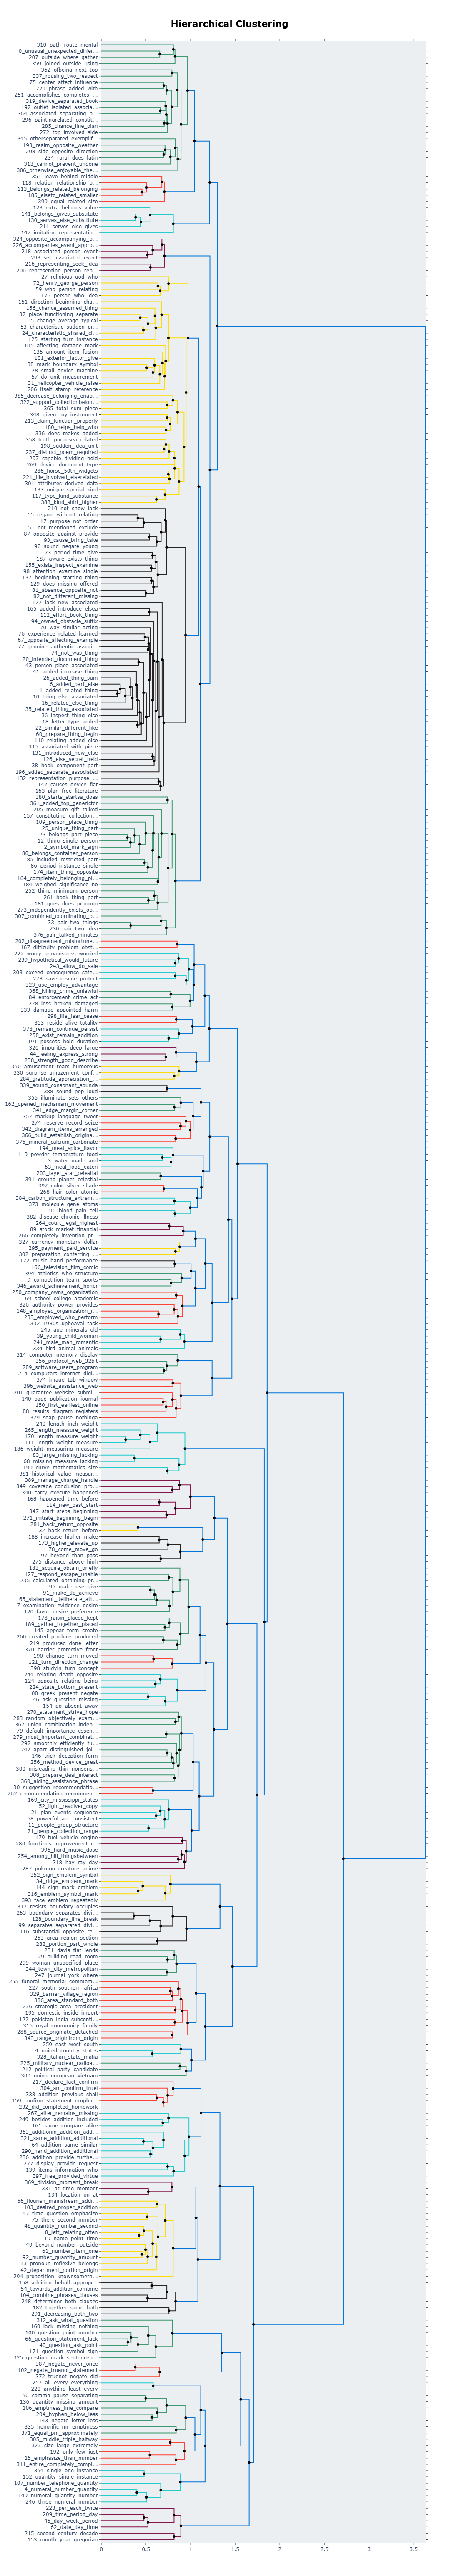

In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
#topic_model.visualize_document_datamap(docs, embeddings=np.array(w_dec))
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 398/398 [00:01<00:00, 261.66it/s]


In [ ]:
#import datamapplot
#fig = topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)
#fig.savefig("/mnt/c/temp/datampa.png", bbox_inches="tight")

#topic_model.visualize_documents(docs, embeddings=np.array(w_dec), )

#tree = topic_model.get_topic_tree(hierarchical_topics, tight_layout=True)
#tree

hierarchical_topics[hierarchical_topics.Topics.map(lambda x: 354 in x)]

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
397,796,is_thing_that_something_to,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",780,thing_else_person_that_something,795,number_in_it_of_quantity,3.634198
396,795,number_in_it_of_quantity,"[3, 4, 7, 8, 9, 11, 13, 14, 15, 19, 21, 29, 30...",794,and_can_of_refer_in,791,number_quantity_time_addition_indicate,2.712764
392,791,number_quantity_time_addition_indicate,"[8, 13, 14, 15, 19, 40, 42, 45, 47, 48, 49, 50...",781,addition_number_two_indicate_additional,790,number_quantity_day_period_time,1.705196
391,790,number_quantity_day_period_time,"[14, 15, 40, 45, 50, 62, 66, 100, 102, 106, 10...",789,number_quantity_question_than_numeral,706,day_period_date_month_time,1.656654
390,789,number_quantity_question_than_numeral,"[14, 15, 40, 50, 66, 100, 102, 106, 107, 136, ...",783,question_statement_negate_lack_ask,768,number_quantity_than_numeral_amount,1.562494
369,768,number_quantity_than_numeral_amount,"[14, 15, 50, 106, 107, 136, 143, 149, 152, 192...",761,number_than_emphasize_quantity_small,701,number_numeral_quantity_numerical_10,1.162221
302,701,number_numeral_quantity_numerical_10,"[14, 107, 149, 152, 246, 354]",440,single_instance_one_quantity_number,538,numeral_number_quantity_numerical_10,0.885203
41,440,single_instance_one_quantity_number,"[152, 354]",354,single_one_instance_individual_number,152,quantity_single_instance_number_item,0.479549


Lastly, it would be advised to save the model as follows:

In [ ]:
topic_model.save(
    path='/content/drive/MyDrive/model_dir',
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model="sentence-transformers/all-MiniLM-L6-v2"
)

# **Advanced Tips & Tricks**

There are a number of advanced tips and tricks that you can use to make it a bit easier and more flexible to train your model at large datasets.

## UMAP

Just like we pre-computed the embeddings, we can pre-reduce the dimensionality of the embeddings with cuML's UMAP and use those.

This saves quite a bit of time since we need to reduce embeddings everytime we run BERTopic.

**NOTE**: Saving those embeddings, as we did before, is generally advised.

In [ ]:
from cuml.manifold import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=5, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings = umap_model.fit_transform(embeddings)

[D] [22:09:12.000791] /__w/cuml/cuml/cpp/src/umap/runner.cuh:107 n_neighbors=15
[D] [22:09:12.001570] /__w/cuml/cuml/cpp/src/umap/runner.cuh:129 Calling knn graph run
[D] [22:09:12.244371] /__w/cuml/cuml/cpp/src/umap/runner.cuh:135 Done. Calling fuzzy simplicial set
[D] [22:09:12.245916] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:318 Smooth kNN Distances
[D] [22:09:12.246008] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:320 sigmas = [ 0.0500507, 0.0281283, 0.0262531, 0.0198846, 0.18011, 0.0422783, 0.0422468, 0.177304, 0.118867, 0.0856781, 0.199346, 0.0365258, 0.244307, 0.132606, 0.229625, 0.00576204, 0.278808, 0.0820699, 0.225413, 0.165649, 0.0198817, 0.0872321, 0.112002, 0.0159094, 0.221684 ]

[D] [22:09:12.246051] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:322 rhos = [ 0.226658, 0.151736, 0.169301, 0.289636, 5.96046e-08, 0.224979, 0.23612, 5.96046e-08, 5.96046e-08, 0.238281, 2.98023e-07, 0.108141, 2.38419e-07, 2.38419e-07, 5.96046e-08, 0.201792, 1.78814

Similarly, we can also prepare the UMAP-reduced embeddings for visualizing documents in 2D:

In [ ]:
from cuml.manifold import UMAP

# Train model and reduce dimensionality of embeddings
umap_model = UMAP(n_components=2, n_neighbors=15, random_state=42, metric="cosine", verbose=True)
reduced_embeddings_2d = umap_model.fit_transform(embeddings)

[D] [22:09:15.352466] /__w/cuml/cuml/cpp/src/umap/runner.cuh:107 n_neighbors=15
[D] [22:09:15.353491] /__w/cuml/cuml/cpp/src/umap/runner.cuh:129 Calling knn graph run
[D] [22:09:15.507770] /__w/cuml/cuml/cpp/src/umap/runner.cuh:135 Done. Calling fuzzy simplicial set
[D] [22:09:15.508972] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:318 Smooth kNN Distances
[D] [22:09:15.509108] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:320 sigmas = [ 0.0500507, 0.0281283, 0.0262531, 0.0198846, 0.18011, 0.0422783, 0.0422468, 0.177304, 0.118867, 0.0856781, 0.199346, 0.0365258, 0.244307, 0.132606, 0.229625, 0.00576204, 0.278808, 0.0820699, 0.225413, 0.165649, 0.0198817, 0.0872321, 0.112002, 0.0159094, 0.221684 ]

[D] [22:09:15.509160] /__w/cuml/cuml/cpp/src/umap/fuzzy_simpl_set/naive.cuh:322 rhos = [ 0.226658, 0.151736, 0.169301, 0.289636, 5.96046e-08, 0.224979, 0.23612, 5.96046e-08, 5.96046e-08, 0.238281, 2.98023e-07, 0.108141, 2.38419e-07, 2.38419e-07, 5.96046e-08, 0.201792, 1.78814

## HDBSCAN

We can even pre-compute the clusters with HDBSCAN and feed them to BERTopic to perform [manual topic modeling](https://maartengr.github.io/BERTopic/getting_started/manual/manual.html). Manual topic modeling with BERTopic means that if we already have labels of topics, we can use those to label them using a variety of [representation models](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html).

BERTopic can still perform inference since inference is done on topic embeddings that are created during `fit`.

In [ ]:
from cuml.cluster import HDBSCAN

# Find clusters of semantically similar documents
hdbscan_model = HDBSCAN(min_samples=30, gen_min_span_tree=True, prediction_data=False, min_cluster_size=30, verbose=True)
clusters = hdbscan_model.fit(reduced_embeddings).labels_

## Manual BERTopic

When we have pre-computed labels, we can pass them instead of having to calculate the clusters ourselves. This allows us to skip over the embedding, dimensionality, and clustering steps!

There is one more trick though that we are going to use. We could directly give BERTopic the reduced embeddings but BERTopic will use those to create topic vectors which is not ideal. Instead, we are giving the model the full embeddings and create a custom dimensionality reduction class that will return the reduced embeddings. This gives us the best of both worlds!

In [ ]:
from cuml.cluster import HDBSCAN
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from bertopic.cluster import BaseCluster
from bertopic.representation import KeyBERTInspired


class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings


# Prepare sub-models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = Dimensionality(reduced_embeddings)
hdbscan_model = BaseCluster()
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")
representation_model = KeyBERTInspired()

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        verbose=True
).fit(docs, embeddings=embeddings, y=clusters)

NameError: name 'clusters' is not defined

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1138,-1_used_specific_indicate_time,"[used, specific, indicate, time, example, rela...",[something that is related to or belongs to a ...
1,0,257,0_mark_symbol_sign_suggestion,"[mark, symbol, sign, suggestion, emblem, high,...","[a certain quantity or amount"". It is often us..."
2,1,215,1_thing_person_idea_associated,"[thing, person, idea, associated, place, belon...","[something in addition to or along with"". It i..."
3,2,184,2_reside_thing_associated_portugal,"[reside, thing, associated, portugal, animatio...",[a thing or person that belongs to a particula...
4,3,171,3_given_highest_important_significant,"[given, highest, important, significant, sent,...","[the highest point of something"" or ""the most ..."
...,...,...,...,...,...
306,305,20,305_atmosphere_declare_question_platform,"[atmosphere, declare, question, platform, offe...","[a level surface, point, or foundation upon wh..."
307,306,20,306_send_listen_initiate_pay,"[send, listen, initiate, pay, start, tenth, hu...","[to start, initiate, or begin something."" It i..."
308,307,20,307_university_crops_college_constant,"[university, crops, college, constant, essence...","[a single, powerful act or initiative"". It is ..."
309,308,20,308_protocol_network_paved_road,"[protocol, network, paved, road, substance, le...",[a road or a passage that traverses bodies of ...


## Visualize Documents

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9576,-1_thing_used_person_refer,"[thing, used, person, refer, indicate, specifi...","[a thing used in a specific way, an instrument..."
1,0,453,0_addition_additional_included_list,"[addition, additional, included, list, informa...","[in addition to"" or ""furthermore"". It is often..."
2,1,353,1_relating_related_indicate_relationship,"[relating, related, indicate, relationship, ex...","[of, relating to, or used in the context of"". ..."
3,2,336,2_thing_person_idea_place,"[thing, person, idea, place, belongs, book, ex...","[a thing; something"". It is an indefinite arti..."
4,3,313,3_piece_portion_larger_object,"[piece, portion, larger, object, refer, thing,...","[a piece of something"". It can be used to refe..."
...,...,...,...,...,...
70,69,20,69_end_final_point_sequence,"[end, final, point, sequence, finally, complet...",[the last or most important element or point i...
71,70,20,70_company_organization_corporation_profit,"[company, organization, corporation, profit, b...","[a company, organization, or government body t..."
72,71,20,71_admired_person_importance_achievements,"[admired, person, importance, achievements, re...","[a person, place, thing, or event that is admi..."
73,72,20,72_remain_continue_stop_cease,"[remain, continue, stop, cease, doing, stopped...","[still"" or ""remaining"". It can be used to refe..."


In [ ]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

ValueError: 0        #46f0f0
2        #9a6324
3        #ffe119
6        #46f0f0
7        #f58231
          ...   
16373    #808000
16374    #3cb44b
16375    #4363d8
16378    #f032e6
16380    #4363d8
Name: Topic, Length: 6808, dtype: object is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

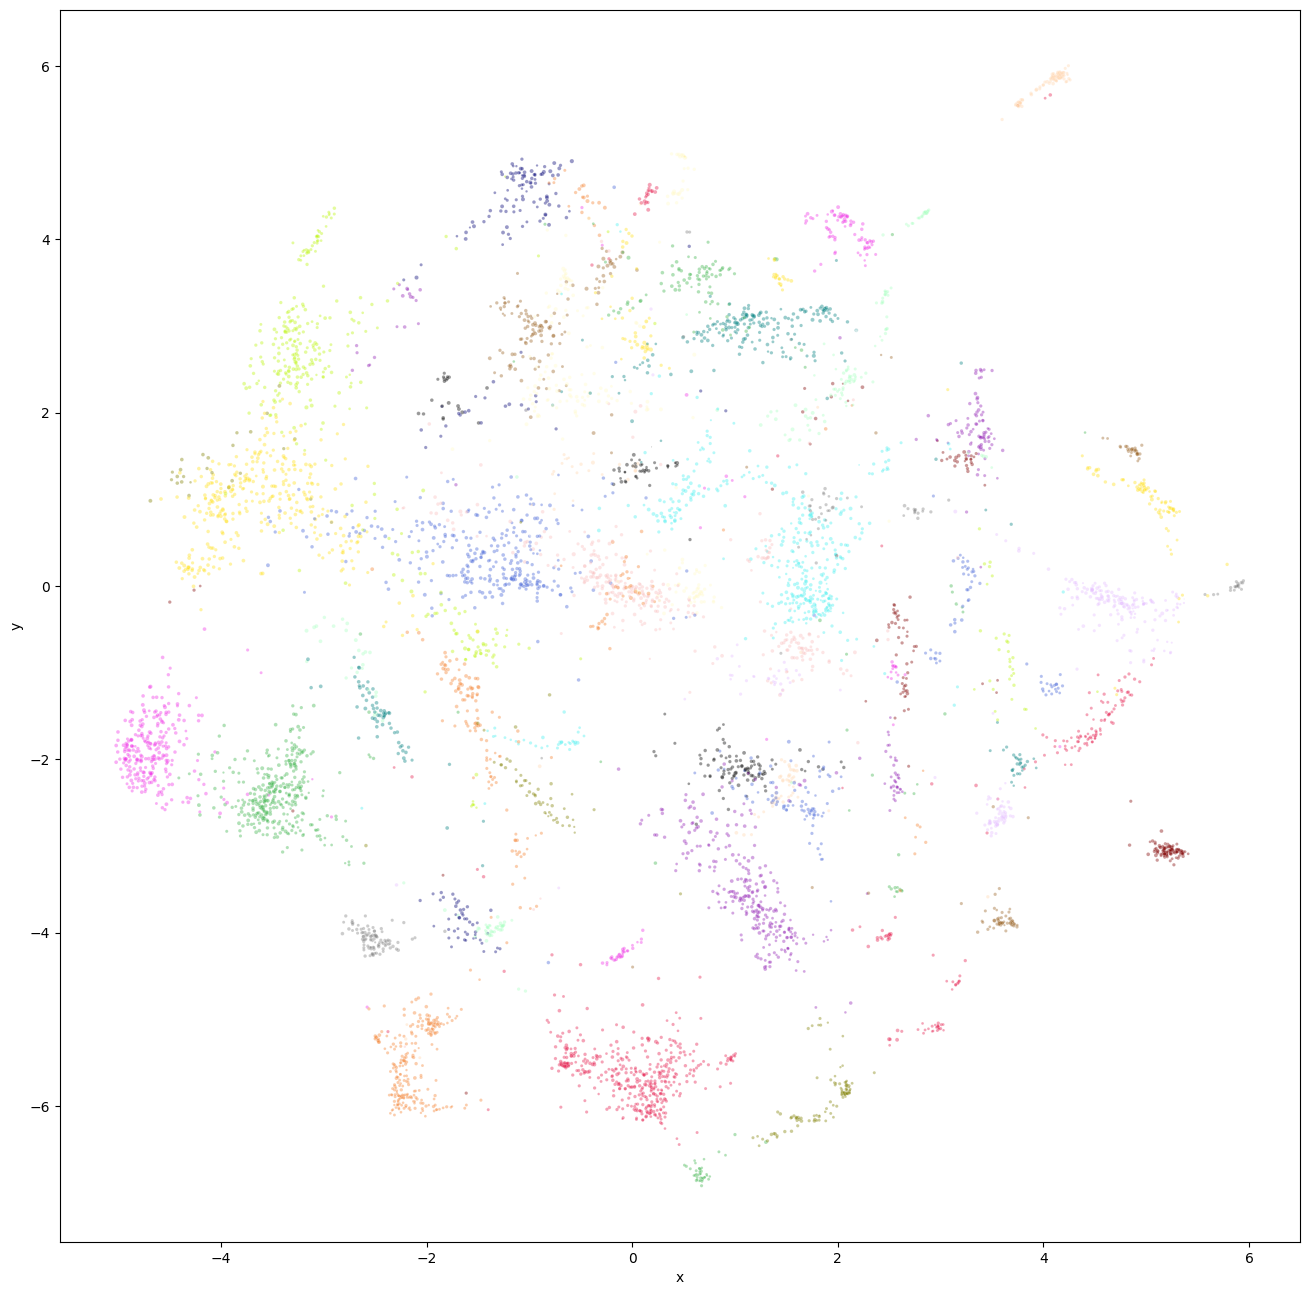

In [ ]:

import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
# plt.savefig("visualization2.png", dpi=600)